In [62]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value

################################
# load data, missing, outliers #
################################
combined_dataset_step1 <- 
    house_prices$helpers$load_data() %>%
    (house_prices$stage1_transformation)

################################
# transform numeric predictors #
################################
step2 <- house_prices$stage2_transformation(
    combined_dataset_step1,
    threshold = 20
)
trans_config <- step2$trans_config
combined_dataset_step2 <- step2$dataset
                
trans_config

house_prices$helpers$utils$frames_diff(
    combined_dataset_step1, 
    combined_dataset_step2
) %>% head

####################################                
# transform categorical predictors #
####################################
combined_dataset_step3 <- house_prices$stage3_transformation(combined_dataset_step2)

house_prices$helpers$utils$frames_diff(
    combined_dataset_step2, 
    combined_dataset_step3
) %>% head

training_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

showtable <- house_prices$helpers$showtable

var,tran_name,progress_score,tran_fn,r2_x,r2_tran
GrLivArea,log,91.15794,"function (x) , log(x + 1)",0.52593095,0.5438044
LotArea,inv4,78.86403,"function (x) , x^(1/4)",0.06788313,0.1591873
TotRmsAbvGrd,log,30.68502,"function (x) , log(x + 1)",0.28912299,0.2938676


GrLivArea.1,GrLivArea.2,LotArea.1,LotArea.2,TotRmsAbvGrd.1,TotRmsAbvGrd.2
1710,7.444833,8450,9.587694,8,2.197225
1262,7.141245,9600,9.898464,6,1.945910
1786,7.488294,11250,10.298836,6,1.945910
1717,7.448916,9550,9.885550,7,2.079442
2198,7.695758,14260,10.927728,9,2.302585
1362,7.217443,14115,10.899842,5,1.791759


Alley.1,Alley.2,BldgType.1,BldgType.2,BsmtCond.1,BsmtCond.2,BsmtExposure.1,BsmtExposure.2,BsmtFinType1.1,BsmtFinType1.2,⋯,RoofStyle.1,RoofStyle.2,SaleCondition.1,SaleCondition.2,SaleType.1,SaleType.2,Street.1,Street.2,Utilities.1,Utilities.2
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Gd,3.295455,ALQ,2.231818,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Mn,2.675439,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,Gd,3.046154,No,2.320042,ALQ,2.231818,⋯,Gable,2.418054,Abnorml,1.920792,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,Av,2.900452,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911
_none_,2.531822,1Fam,2.564039,TA,2.540871,No,2.320042,GLQ,3.262019,⋯,Gable,2.418054,Normal,2.451586,WD,2.421468,Pave,2.499311,AllPub,2.496911


In [63]:
iterate <- purrr::partial(house_prices$validate$iterate, 
                          target_var = price_log,
                          categ_transform = house_prices$trans$categ$rating_transform)

get_avg_report <- house_prices$validate$get_avg_report

In [81]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset %>% select(-Id), 
    target_var = price_log, 
    r2_gain_discard_level = 0.1,
    r2_discard_level = 0.01, 
    a_max = 0, a_avg = 1
)

formulas_for_validation <-
    report %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

validation_dataset <-
    # !!!before transformation of categ variables!!!
    combined_dataset_step2 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

validation_dataset %>% nrow %>% print

set.seed(8)

report <- suppressWarnings(
    caret::createDataPartition(
        y = validation_dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation, sample_index, dataset) })
) %>% 
bind_rows(.id='sample')

[1] 1458


In [67]:
formulas_for_validation

step,formula
1,price_log ~ OverallQual
2,price_log ~ OverallQual + LotArea
3,price_log ~ OverallQual + LotArea + GrLivArea
4,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt
5,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1
6,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd
7,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition
8,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir
9,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood
10,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF


In [69]:
report %>% group_by(sample) %>% filter(row_number() %in% c(1, 2, 10))

sample,step,formula,r2,L2_train,L2_test
Resample01,1,price_log ~ OverallQual,0.6790126,0.05179864,0.05219710
Resample01,2,price_log ~ OverallQual + LotArea,0.7467464,0.04086824,0.04039229
Resample01,10,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8944944,0.01702574,0.01738037
Resample02,1,price_log ~ OverallQual,0.6815423,0.04753301,0.05637917
Resample02,2,price_log ~ OverallQual + LotArea,0.7464122,0.03785053,0.04332776
Resample02,10,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8890778,0.01655626,0.01843275
Resample03,1,price_log ~ OverallQual,0.6413272,0.05558129,0.04828376
Resample03,2,price_log ~ OverallQual + LotArea,0.7210459,0.04322778,0.03781819
Resample03,10,price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8762578,0.01917556,0.01502430
Resample04,1,price_log ~ OverallQual,0.6632645,0.05362075,0.05051280


In [66]:
avg_report <- report %>% get_avg_report
avg_report

formula,r2,L2_train,L2_test,step,L2_test_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + LotArea,0.7425354,0.04048551,0.04067756,2,0.0118252136
price_log ~ OverallQual + LotArea + GrLivArea,0.7924489,0.03263215,0.03304361,3,0.0076339501
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt,0.8343216,0.02604849,0.02613031,4,0.0069132999
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1,0.8568478,0.02250598,0.02208950,5,0.0040408068
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd,0.8659281,0.02107985,0.02071659,6,0.0013729125
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition,0.8728139,0.01999517,0.01992818,7,0.0007884139
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir,0.8774142,0.01926655,0.01914890,8,0.0007792735
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood,0.8842388,0.01819172,0.01820365,9,0.0009452507
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8890352,0.01743614,0.01727302,10,0.0009306299


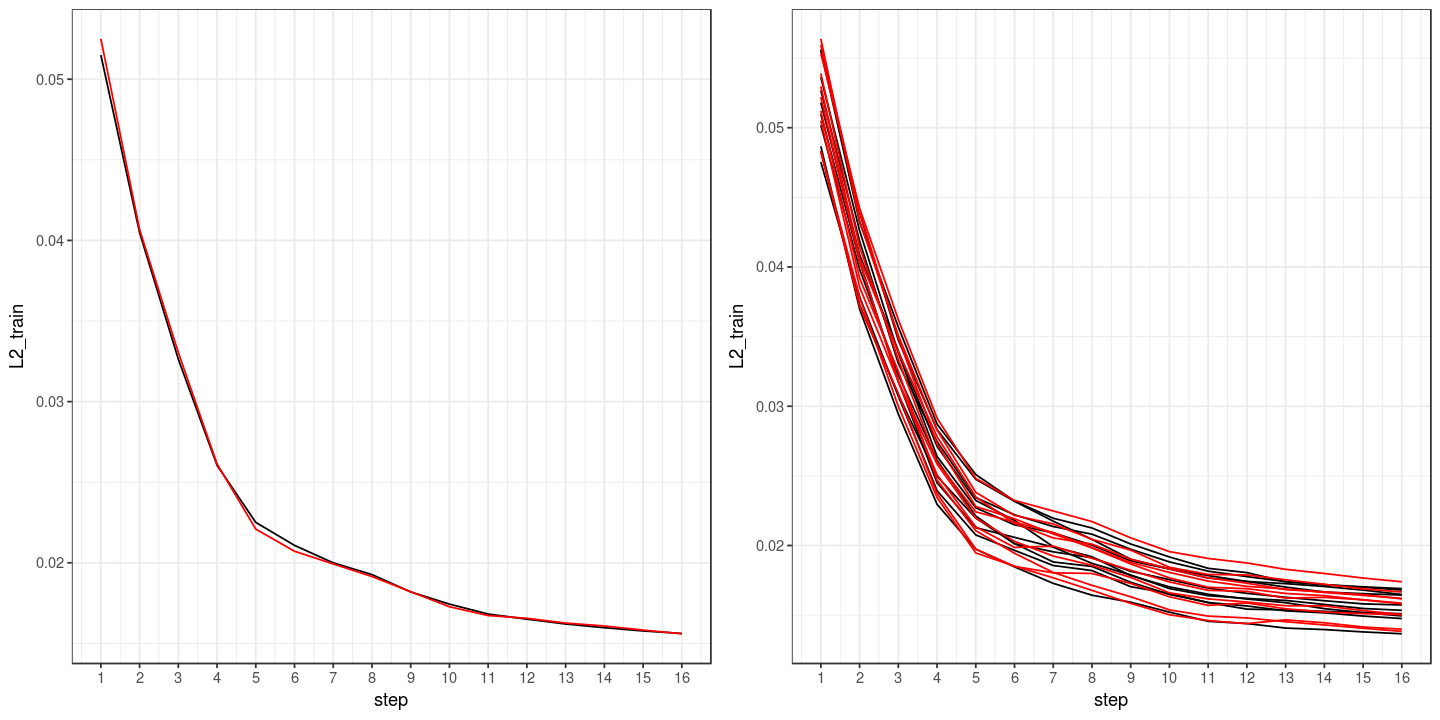

In [75]:
options(repr.plot.width = 12, repr.plot.height = 6)
house_prices$validate$plot_report(report)

In [82]:
report <- house_prices$model_selection$lm$greedy_r2_gain_adj(
    data = training_dataset, 
    target_var = price_log, 
    r2_gain_discard_level = 0.1,
    r2_discard_level = 0.01, 
    a_max = 0, a_avg = 1
)

formulas_for_validation <-
    report %>% 
    group_by(step) %>% 
    filter(row_number() == 1) %>%
    select(step, formula)

validation_dataset <-
    # !!!before transformation of categ variables!!!
    combined_dataset_step2 %>% 
    filter(dataSource == 'train') %>% 
    select(-dataSource)

validation_dataset %>% nrow %>% print

set.seed(8)
report2 <- suppressWarnings(
    caret::createDataPartition(
        y = dataset[['price_log']], 
        p = 0.5, 
        list = TRUE, 
        times = 10
    ) %>%
    map(function (sample_index) { iterate(formulas_for_validation, sample_index, dataset) })
) %>% 
bind_rows(.id='sample')

avg_report2 <- report2 %>% get_avg_report
avg_report2

[1] 1458


formula,r2,L2_train,L2_test,step,L2_test_gain
price_log ~ OverallQual,0.6724516,0.05149759,0.05250277,1,NA
price_log ~ OverallQual + LotArea,0.7425354,0.04048551,0.04067756,2,0.0118252136
price_log ~ OverallQual + LotArea + GrLivArea,0.7924489,0.03263215,0.03304361,3,0.0076339501
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt,0.8343216,0.02604849,0.02613031,4,0.0069132999
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1,0.8568478,0.02250598,0.02208950,5,0.0040408068
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd,0.8659281,0.02107985,0.02071659,6,0.0013729125
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition,0.8728139,0.01999517,0.01992818,7,0.0007884139
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir,0.8774142,0.01926655,0.01914890,8,0.0007792735
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood,0.8842388,0.01819172,0.01820365,9,0.0009452507
price_log ~ OverallQual + LotArea + GrLivArea + YearBuilt + BsmtFinSF1 + YearRemodAdd + SaleCondition + CentralAir + Neighborhood + TotalBsmtSF,0.8890352,0.01743614,0.01727302,10,0.0009306299


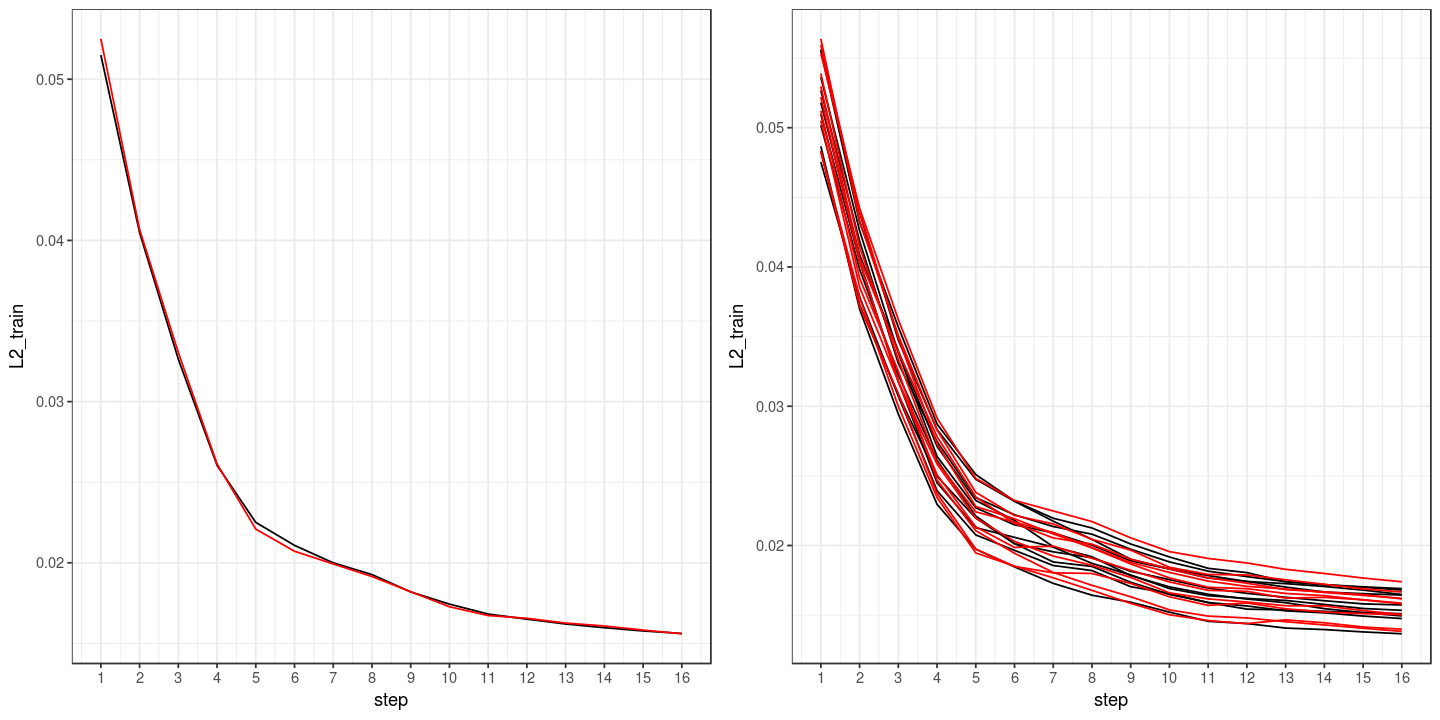

In [83]:
options(repr.plot.width = 12, repr.plot.height = 6)
house_prices$validate$plot_report(report2)

In [ ]:
model <- lm(price_log ~ OverallQual + GrLivArea + Neighborhood + 
            BsmtFinSF1 + GarageArea + CentralAir + LotArea + 
            YearRemodAdd + TotalBsmtSF + SaleCondition + Condition1 + 
            KitchenQual + Fireplaces + MSZoning + ScreenPorch, data=training_dataset %>% select(-Id))

testing_dataset <- 
    combined_dataset_step3 %>% 
    filter(dataSource == 'test') %>% 
    select(-dataSource)

submit <- 
    testing_dataset %>%
    mutate(
        predicted = predict(model, testing_dataset)
    ) %>%
    select(Id, predicted) %>%
    mutate(
        SalePrice = exp(predicted)
    ) %>%
    select(Id, SalePrice)

write.csv(submit, "submission.csv", row.names = FALSE)